In [1]:
from qiskit import IBMQ
from qiskit import pulse, assemble
from qiskit.pulse import DriveChannel, ControlChannel, Play, Schedule
from qiskit.visualization import plot_histogram
from parametric_cz_builder import ParametericCZBuilder
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import json

import qiskit.tools.jupyter
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-university', group='uni-pittsburgh', project='main')
backend = provider.get_backend('ibmq_casablanca')

C:\Users\jsten\Anaconda3\envs\qiskit20_new\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [2]:
#Backend specifications

backend_config = backend.configuration()
dt = backend_config.dt

backend_defaults = backend.defaults()
inst_sched_map = backend_defaults.instruction_schedule_map

In [3]:
#Helper functions for the ZX gate

def get_ctrl_chan(qc: int, qt: int) -> ControlChannel:
    cx = inst_sched_map.get('cx', qubits=[qc, qt])
    idx = 0
    while (type(cx.instructions[idx][1].channels[0]) is not ControlChannel) or (type(cx.instructions[idx][1]) is not Play):
        idx += 1
    return cx.instructions[idx][1].channels[0]

def cx_in_forward_direction(qc: int, qt: int) -> bool:
    qc_num_inst_forward = len(inst_sched_map.get('cx', qubits=[qc, qt]))
    qc_num_inst_reverse = len(inst_sched_map.get('cx', qubits=[qt, qc]))
    if qc_num_inst_forward < qc_num_inst_reverse:
        return True
    else:
        return False
    
def print_forward_pairs(backend):
    backend_defaults = backend.defaults()
    inst_sched_map = backend_defaults.instruction_schedule_map
    for pair in inst_sched_map.qubits_with_instruction('cx'):
        if cx_in_forward_direction(qc=pair[0], qt=pair[1]):
            print('Qubit Pair (%i,%i) is in the forward direction' %(pair[0],pair[1]))
            
    return

In [4]:
#Gates


# 90 degree single qubit gates
def apply_u2(qubit, phi, lamb) -> Schedule:
    return inst_sched_map.get('u2', P0=phi, P1=lamb, qubits=[qubit])

def apply_X90p(qubit) -> Schedule:
    return apply_u2(qubit, phi=-np.pi/2, lamb=np.pi/2) 

def apply_X90m(qubit) -> Schedule:
    return apply_u2(qubit, phi=np.pi/2, lamb=-np.pi/2)

def apply_Y90p(qubit) -> Schedule:
    return apply_u2(qubit, phi=0, lamb=0)

def apply_Y90m(qubit) -> Schedule:
    return apply_u2(qubit, phi=np.pi, lamb=np.pi)

def apply_Z90p(qubit):
    return inst_sched_map.get('u1', P0=-np.pi/2, qubits=[qubit])

def apply_Z90m(qubit):
    return inst_sched_map.get('u1', P0=np.pi/2, qubits=[qubit])



# 180 degree single qubit gates
def apply_X(qubit) -> Schedule:
    return inst_sched_map.get('x', qubits=[qubit])

def apply_Y(qubit) -> Schedule:
    with pulse.build() as sched:
        with pulse.phase_offset(np.pi/2, DriveChannel(qubit)):  
            pulse.call(apply_X(qubit))
    return sched

def apply_Z(qubit):
    return inst_sched_map.get('u1', P0=np.pi, qubits=[qubit])



# Single qubit rotation gates
def apply_Rz(qubit,phi):
    return inst_sched_map.get('u1', P0=-phi, qubits=[qubit])

def apply_Rx(qubit,phi):
    return inst_sched_map.get('u3', P0=phi, P1=-np.pi/2, P2=np.pi/2, qubits=[qubit])

def apply_Ry(qubit,phi):
    return inst_sched_map.get('u3', P0=phi, P1=0.0, P2=0.0, qubits=[qubit])



# Two qubit rotation gates
def apply_atomic_ZX(qc, qt, theta) -> Schedule:
    if cx_in_forward_direction(qc=qc, qt=qt):
        scaled_atomic_zx = ParametericCZBuilder(backend)
        #print('ZX theta angle is %.3f' %theta)
        return scaled_atomic_zx.parameterized_cx(theta, qc, qt)
    else:
        print('Atomic ZX applied in wrong direction!')
        return None

def apply_Rzx(qc, qt, theta) -> Schedule: 
    with pulse.build(name="Echoed ZX") as sched:
        if cx_in_forward_direction(qc=qc, qt=qt):
            with pulse.align_sequential():
                pulse.call(apply_atomic_ZX(qc, qt, theta))
                pulse.call(apply_X(qc))
        else:
            with pulse.align_sequential():
                pulse.call(apply_Y90p(qt))
                pulse.call(apply_Y90m(qc))
                pulse.call(apply_atomic_ZX(qt, qc, theta))
                pulse.call(apply_Y90p(qc))
                pulse.call(apply_Y90m(qt))
    return sched

In [5]:
def apply_U(cx,w,dt):
    w0 = w+1
    with pulse.build() as sched:
        with pulse.align_sequential():
            
            #Ua
            pulse.call(apply_Rz(0,-dt))
            
            #Uc
            pulse.call(apply_Rz(1,w0*dt))
            
            #Ud
            pulse.call(apply_Rx(2,mu*dt))
            
            #Ue
            pulse.call(apply_Rzx(1,2,-mu*dt))
            
            #Uf
            pulse.call(apply_Ry(0,-np.pi))
            pulse.call(apply_Rzx(0,1,2*cx*dt))
            pulse.call(apply_Ry(0,np.pi/2))
            
            #######################################################
            
            #Uf
            pulse.call(apply_Ry(0,-np.pi))
            pulse.call(apply_Rzx(0,1,2*cx*dt))
            pulse.call(apply_Ry(0,np.pi/2))
            
            #Ue
            pulse.call(apply_Rzx(1,2,-mu*dt))
            
            #Ud
            pulse.call(apply_Rx(2,mu*dt))
            
            #Uc
            pulse.call(apply_Rz(1,w0*dt))
            
            #Ua
            pulse.call(apply_Rz(0,-dt))
            
            
    return sched
            


In [46]:
cx = 0.1
mu = 0.7
w = 0.5
#dt=0.5
dt=0.1


#apply_U(cx,w,dt).draw()
#apply_U(cx,w,dt)



In [47]:
from qiskit import QuantumCircuit
from qiskit.compiler import transpile, schedule

qubits = [0,1,2]

meas_circ = QuantumCircuit(3, 3)
meas_circ.measure(qubits, qubits)
#meas_circ.draw()

meas_sched = schedule(transpile(meas_circ, backend=backend, output_name='measure'), backend=backend)

In [48]:
def Ut(cx,w,dt,t):
    with pulse.build() as sched:
        with pulse.align_sequential():
            for tn in range(0,int(t/dt)):
                ti = tn*dt
                pulse.call(apply_U(cx,w,dt))

            pulse.call(meas_sched)
    return sched
          

In [49]:
cx = 0.1
mu = 0.7
t = 5
dt = 0.5

#Ut(cx,0.5,dt,t)

In [50]:
exp_scheds = []
wl = [wi*0.03-1.5 for wi in range(0,100)]

for w in wl:
    exp_scheds.append(Ut(cx,w,dt,t))

experiment = assemble(exp_scheds, backend=backend, meas_level=2, shots=8192)

In [51]:
# RUN the job on a real device
job = backend.run(experiment)
print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

603d32287a77b1a2b73e8859
Job Status: job has successfully run


In [52]:
results = job.result()

#results.get_counts()[0]

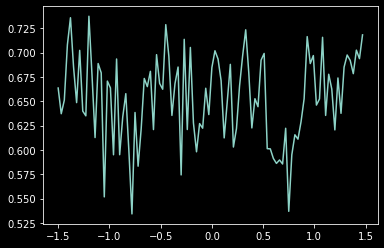

In [53]:
zr = job.result().get_counts()
pz = [(zr[i]['0000000']-zr[i]['0000001'])/(zr[i]['0000000']+zr[i]['0000001']) for i in range(len(wl))]

#marker = [1 for i in e0]

plt.plot(wl,pz)
#plt.scatter(e0,marker)
plt.show()

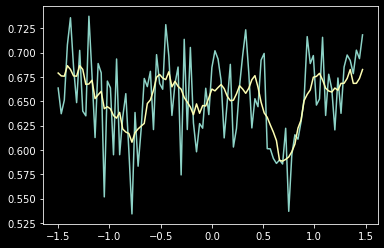

In [55]:
pz_avg = []
n = 8
for i in range(0,len(pz)):
    avg = 0
    if i-int(n/2) > 0 and i + int(n/2) < len(pz):
        avg = sum([pz[j] for j in range(i-int(n/2),i+int(n/2))])/n
        pz_avg.append(avg)
    elif i + n < len(pz):
        avg = sum([pz[j] for j in range(i,i+n)])/n
        pz_avg.append(avg)
    else:
        avg = sum([pz[j] for j in range(i-n,i)])/n
        pz_avg.append(avg)
    
plt.plot(wl,pz)
plt.plot(wl,pz_avg)
plt.show()

### Data from dt = 0.5

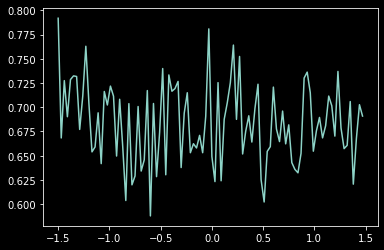

In [25]:
zr = job.result().get_counts()
pz = [(zr[i]['0000000']-zr[i]['0000001'])/(zr[i]['0000000']+zr[i]['0000001']) for i in range(len(wl))]

#marker = [1 for i in e0]

plt.plot(wl,pz)
#plt.scatter(e0,marker)
plt.show()

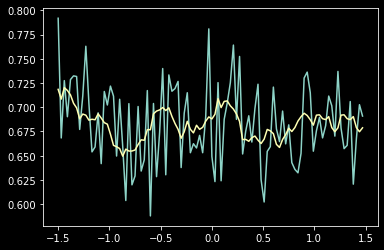

In [45]:
pz_avg = []
n = 8
for i in range(0,len(pz)):
    avg = 0
    if i + n < len(pz):
        avg = sum([pz[j] for j in range(i,i+n)])/n
        pz_avg.append(avg)
    else:
        avg = sum([pz[j] for j in range(i-n,i)])/n
        pz_avg.append(avg)
    
plt.plot(wl,pz)
plt.plot(wl,pz_avg)
plt.show()